<a href="https://colab.research.google.com/gist/janlukasschroeder/907db34a93f1970b0fd983595dc4123c/insider-trading-api-example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install sec-api

In [2]:
from sec_api import InsiderTradingApi

insiderTradingApi = InsiderTradingApi("YOUR_API_KEY")

In [3]:
insider_trades = insiderTradingApi.get_data({
  "query": {"query_string": {"query": "issuer.tradingSymbol:TSLA"}},
  "from": "0",
  "size": "50",
  "sort": [{ "filedAt": { "order": "desc" } }]
})

The most recent trading transactions performed by Telsa insiders are included in the `insider_trades["transactions"]` list. Each list item represents one Form 4 filing containing all derivative and non-derivate transactions per filing and reporting person.

The next section illustrates how to simplify the insider transaction data so that it can be loaded into a Pandas dataframe for further analysis and data visualization.

In [4]:
import pandas as pd
import math

In [5]:
def flatten_filing(filing):
  transactions = []

  # data points to be added to each transaction
  base_data = {"periodOfReport": filing["periodOfReport"], 
               "issuerCik": filing["issuer"]["cik"],
               "issuerTicker": filing["issuer"]["tradingSymbol"],
               "reportingPerson": filing["reportingOwner"]["name"]
               }

  # ignore filing in case no non-derivative transactions was reported
  if "transactions" not in filing["nonDerivativeTable"]:
    return []

  # extract the data points of interest from each transaction
  for transaction in filing["nonDerivativeTable"]["transactions"]:
    entry = {"securityTitle": transaction["securityTitle"],
             "codingCode": transaction["coding"]["code"],
             "acquiredDisposed": transaction["amounts"]["acquiredDisposedCode"],
             "shares": transaction["amounts"]["shares"],
             "sharePrice": transaction["amounts"]["pricePerShare"],
             "total": math.ceil(transaction["amounts"]["shares"] * transaction["amounts"]["pricePerShare"]),
             "sharesOwnedFollowingTransaction": transaction["postTransactionAmounts"]["sharesOwnedFollowingTransaction"]
             }

    # merge base_data and entry into a new dict and append to transactions
    transactions.append({**base_data, **entry})

  return transactions


# create a simplified list of all transactions per filing 
# with just a handful of data points, e.g. reporting person, shares sold, etc.
def flatten_filings(filings):
  unflattened_list = list(map(flatten_filing, filings))
  return [item for sublist in unflattened_list for item in sublist]


transactions = flatten_filings(insider_trades["transactions"])

df = pd.DataFrame(transactions)

df.drop_duplicates(subset=["reportingPerson"]).head(10)

,periodOfReport,issuerCik,issuerTicker,reportingPerson,securityTitle,codingCode,acquiredDisposed,shares,sharePrice,total,sharesOwnedFollowingTransaction
0,2022-08-09,1318605,TSLA,Musk Elon,Common Stock,S,D,435.0,872.469,379525,1.550585e+08
123,2022-07-29,1318605,TSLA,Wilson-Thompson Kathleen,Common Stock,M,A,17500.0,44.950,786625,1.930000e+04
127,2022-07-27,1318605,TSLA,Baglino Andrew D,Common Stock,M,A,3500.0,62.720,219520,2.406700e+04
129,2022-07-25,1318605,TSLA,Musk Kimbal,Common Stock,M,A,25000.0,74.170,1854250,5.362400e+05
132,2022-06-10,1318605,TSLA,Taneja Vaibhav,Common Stock,M,A,2500.0,55.320,138300,2.894925e+04
135,2022-06-05,1318605,TSLA,Kirkhorn Zachary,Common Stock,M,A,215.0,0.000,0,5.953300e+04
144,2022-06-01,1318605,TSLA,DENHOLM ROBYN M,Common Stock,M,A,25000.0,52.380,1309500,3.000000e+04


The dataframe contains a subset of data points of the insider transactions returned by the API. Each dataframe row represents a non-derivative transaction of a Form 4 filing. A Form 4 filing can include up to 30 transactions. That's why more than 700 insider trading transactions were generated from just 50 filings. The column "total" was added to each transaction and represents the total transaction value in dollars (= share price * number of shares). 

The dataframe includes not only Elon Musk's insider activities, but also trades executed by six other Tesla directors, officers and 10% owners. The printed output above shows seven insiders that reported trading activities in the 50 most recent Form 4 filings. Musk's brother Kimbal, Wilson Kathleen, Taneja Vaibhav	to name a few. In the next section we are going to focus on Musk's 450+ trades.

In [6]:
musk_all_transactions = df[df["reportingPerson"]=="Musk Elon"]

musk_sales = musk_all_transactions[musk_all_transactions["acquiredDisposed"]=="D"]

musk_sales.head(10)

,periodOfReport,issuerCik,issuerTicker,reportingPerson,securityTitle,codingCode,acquiredDisposed,shares,sharePrice,total,sharesOwnedFollowingTransaction
0,2022-08-09,1318605,TSLA,Musk Elon,Common Stock,S,D,435.0,872.469,379525,155058484.0
1,2022-08-09,1318605,TSLA,Musk Elon,Common Stock,S,D,13292.0,874.286,11621010,155045192.0
2,2022-08-09,1318605,TSLA,Musk Elon,Common Stock,S,D,6048.0,876.629,5301853,155039144.0
3,2022-08-09,1318605,TSLA,Musk Elon,Common Stock,S,D,18630.0,838.571,15622578,158060742.0
4,2022-08-09,1318605,TSLA,Musk Elon,Common Stock,S,D,8053.0,839.980,6764359,158052689.0
5,2022-08-09,1318605,TSLA,Musk Elon,Common Stock,S,D,106535.0,840.891,89584323,157946154.0
6,2022-08-09,1318605,TSLA,Musk Elon,Common Stock,S,D,224133.0,841.852,188686815,157722021.0
7,2022-08-09,1318605,TSLA,Musk Elon,Common Stock,S,D,114286.0,842.686,96307213,157607735.0
8,2022-08-09,1318605,TSLA,Musk Elon,Common Stock,S,D,114517.0,843.697,96617650,157493218.0
9,2022-08-09,1318605,TSLA,Musk Elon,Common Stock,S,D,90934.0,844.816,76822499,157402284.0


In [7]:
print("Total number of transactions executed by Musk: {}".format(len(musk_sales)))

Total number of transactions executed by Musk: 453


In [8]:
# sum up all transaction values across Musk's insider sales
total_sold = musk_sales["total"].sum()
# find the number of shares owned following
shares_owned_following_transactions = musk_sales[musk_sales["periodOfReport"]=="2022-08-09"]["sharesOwnedFollowingTransaction"].min()

print("Total sold: ${:,.0f}".format(total_sold))
print("Remaining shares {:,.0f}".format(shares_owned_following_transactions))

Total sold: $17,880,517,582
Remaining shares 155,039,144


Elon Musk sold close to $18 billion of his Tesla shares between late December 2021 and August 2022 while still holding 155 million shares as of August 9 2022.

In [9]:
# group all rows by periodOfReport and calculate the sum along all columns 
# to determine how much was sold on a given day in terms of dollars
summed_transactions = musk_sales.groupby(["periodOfReport"]).sum()

# total transaction value in dollars per day of transaction
summed_transactions.loc[:, ["total"]]

,total
periodOfReport,
2021-12-21,528016873
2021-12-22,928571676
2021-12-28,1019774103
2022-04-26,3989322059
2022-04-28,4528088815
2022-08-05,2905562815
2022-08-08,1393278077
2022-08-09,2587903164


Text(0.5, 0, 'Date of sales')

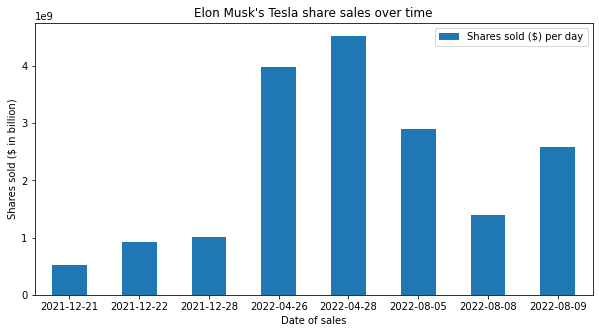

In [10]:
plot = summed_transactions.plot.bar(y="total", 
                                    rot=0, 
                                    figsize=(10, 5), 
                                    title="Elon Musk's Tesla share sales over time",
                                    label="Shares sold ($) per day")
plot.set_ylabel("Shares sold ($ in billion)")
plot.set_xlabel("Date of sales")

Plotting Musk's share sales in a bar chart over time from December 2021 to August 2022 shows a clear selling pattern. Musk likes to sell in four month intervals with the first batch of shares being sold in late December 2021, the next batch in late April 2022, and the most recent batch in August 2022.